# Importing libraries and loading data

In [ ]:
# General and for pre-processing
import numpy as np
import pandas as pd
import pickle
import time
import pywt
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# For spliting data and analysing the accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

# For classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

meta = unpickle('./cifar-100-python/meta')

fine_label_names = [t.decode('utf8') for t in meta[b'fine_label_names']]
coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

train = unpickle('./cifar-100-python/train')

filenames_train = [t.decode('utf8') for t in train[b'filenames']]
fine_labels_train = train[b'fine_labels']
coarse_labels_train = train[b'coarse_labels']
data_train = train[b'data']

test = unpickle('./cifar-100-python/test')

filenames_test = [t.decode('utf8') for t in test[b'filenames']]
fine_labels_test = test[b'fine_labels']
coarse_labels_test = test[b'coarse_labels']
data_test = test[b'data']

In [ ]:
data_test.shape

(10000, 3072)

In [ ]:
def data_to_images(data, change_dtype=False, change_to_array=True):
  '''
  This function convert data in shape (N, 3072)
  into data images with shape (N,32,32,3)
  where N is the number of data
  32 x 32 are the size of image
  3 is the number of channel, RGB
  '''
  images = list()
  for d in data:
    if change_dtype:
      image = np.zeros((32,32,3), dtype=np.uint8)
    else:
      image = np.zeros((32,32,3))
    image[...,0] = np.reshape(d[:1024], (32,32)) # Red channel
    image[...,1] = np.reshape(d[1024:2048], (32,32)) # Green channel
    image[...,2] = np.reshape(d[2048:], (32,32)) # Blue channel
    images.append(image)

  if change_to_array:
    images = np.array(images)

  return images

In [ ]:
images_train = data_to_images(data_train, change_dtype= True)
images_test = data_to_images(data_test, change_dtype= True)

In [ ]:
def show(images,i):  
  '''
  This function is to plot the image with its coarse and fine labels.
  Input 1: list or array of reshaped images e.g. shape (N,32,32,3)
  Input 2: index of the image wish to show
  '''
  image = images[i]
  
  if image.min() < 0:
    image = np.clip(image, 0, 1)

  plt.imshow(image)
  plt.title("Superclass " + str(coarse_labels_train[i]) + ": " + coarse_label_names[coarse_labels_train[i]]+ "\n" \
            "Class " + str(fine_labels_train[i]) + ": " + fine_label_names[fine_labels_train[i]] )
  plt.show()
  plt.close()

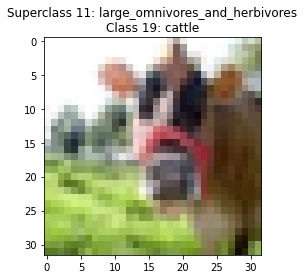

In [ ]:
show(images_train,0)

# Dataset properties and examples of training image

In [ ]:
print(len(meta))
print(meta.keys())

2
dict_keys([b'fine_label_names', b'coarse_label_names'])


In [ ]:
print(type(meta[b'fine_label_names']))
print(type(meta[b'coarse_label_names']))
print(len(meta[b'fine_label_names']))
print(len(meta[b'coarse_label_names']))

<class 'list'>
<class 'list'>
100
20


In [ ]:
print(meta[b'fine_label_names'][:20]) #Classes sorted by alphabet
print(meta[b'coarse_label_names']) #Superclasses

[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle']
[b'aquatic_mammals', b'fish', b'flowers', b'food_containers', b'fruit_and_vegetables', b'household_electrical_devices', b'household_furniture', b'insects', b'large_carnivores', b'large_man-made_outdoor_things', b'large_natural_outdoor_scenes', b'large_omnivores_and_herbivores', b'medium_mammals', b'non-insect_invertebrates', b'people', b'reptiles', b'small_mammals', b'trees', b'vehicles_1', b'vehicles_2']


In [ ]:
print(len(train))
print(train.keys())

5
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [ ]:
print(type(train[b'filenames']))
print(type(train[b'batch_label']))
print(type(train[b'fine_labels']))
print(type(train[b'coarse_labels']))
print(type(train[b'data']))

<class 'list'>
<class 'bytes'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
print(len(train[b'filenames']))
print(len(train[b'batch_label']))
print(len(train[b'fine_labels']))
print(len(train[b'coarse_labels']))
print(train[b'data'].shape)

50000
21
50000
50000
(50000, 3072)


In [ ]:
print(train[b'filenames'][:20])

[b'bos_taurus_s_000507.png', b'stegosaurus_s_000125.png', b'mcintosh_s_000643.png', b'altar_boy_s_001435.png', b'cichlid_s_000031.png', b'phone_s_002161.png', b'car_train_s_000043.png', b'beaker_s_000604.png', b'fog_s_000397.png', b'rogue_elephant_s_000421.png', b'computer_keyboard_s_000757.png', b'willow_tree_s_000645.png', b'sunflower_s_000549.png', b'palace_s_000759.png', b'adriatic_s_001782.png', b'computer_keyboard_s_001277.png', b'bike_s_000682.png', b'wolf_pup_s_001323.png', b'squirrel_s_002467.png', b'sea_s_000678.png']


In [ ]:
print(train[b'data'][:5])

[[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 [124 131 135 ... 232 236 231]
 [ 43  32  87 ...  60  29  37]]


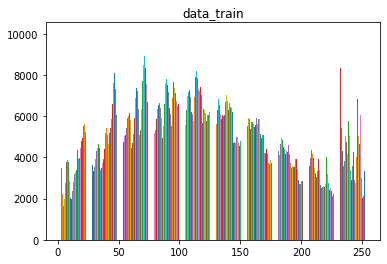

In [ ]:
plt.hist(data_train)
plt.title("data_train")
plt.show()

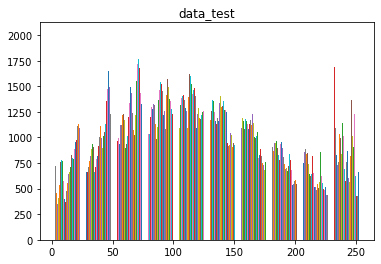

In [ ]:
plt.hist(data_test)
plt.title("data_test")
plt.show()

# Pre-processing datasets

## Standardising

In [ ]:
def standardise(data_train, data_test):
  '''
  This function is used for standardising the data

  Shape of input data: (N,3072)
  Shape of output data: (N,3072)
  '''

  # Get the mean and std dev of training set along its row
  mean = data_train.mean(axis=0)
  stdv = data_train.std(axis=0)

  # Subtract each pixel with the mean
  data_train_standard = (data_train - mean)/stdv
  data_test_standard = (data_test - mean)/stdv


  return data_train_standard, data_test_standard

In [ ]:
# 1. Standardising the data_train and data_test
data_train_standard, data_test_standard = standardise(data_train,data_test)

# 2. Reshape standardised datas
images_train_standard = data_to_images(data_train_standard)
X_test_standard = data_to_images(data_test_standard)

In [ ]:
images_train_standard.max() # Printing the maximum value of the train set

2.658471049704142

In [ ]:
images_train_standard.min()

-2.17379211374196

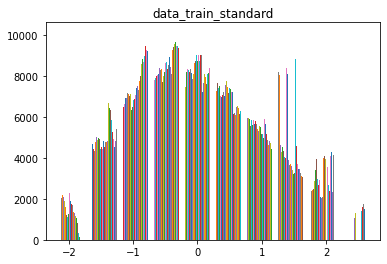

In [ ]:
plt.hist(data_train_standard)
plt.title("data_train_standard")
plt.show()

In [ ]:
plt.hist(data_test_standard)
plt.title("data_test_standard")
plt.show()

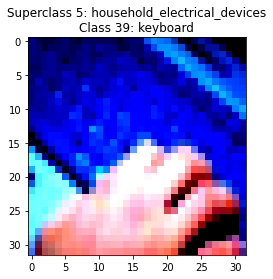

In [ ]:
# 3. Showing an example of standardised image
show(images_train_standard,10)

## Wavelet transform (in multichannel)

In [ ]:
def _wavelet(image,wavelet,wavelet_levels,retain_percent):
  '''
  This helper function is the process of wavelet transforming
  Input1: a channel of a multichannel image OR a grayscaled image
  Input2: type of wavelet
  Input3: wavelet level
  Input4: feature retaining percentage
  Output: a wavelet-transformed channel OR grayscaled image
  '''
  coeffs = pywt.wavedec2(image,wavelet= wavelet, level= wavelet_levels)
  coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
  Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
  thresh_w = Csort[int(np.floor((1-retain_percent)*len(Csort)))]
  ind_w = np.abs(coeff_arr) > thresh_w
  Cfilt = coeff_arr * ind_w
  coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format="wavedec2")
  recon_image = pywt.waverec2(coeffs_filt, wavelet= wavelet)
  return recon_image

def wavelet_transform(image,wavelet,level,retain_percent):
  '''
  This function is to apply wavelet transform to each channel of the image data
  Input1: an image with shape (32,32,3)
  Input2: type of wavelet
  Input3: wavelet level
  Input4: feature retaining percentage
  Output: a wavelet-transformed image with shape (32,32,3)
  '''
  output = np.empty_like(image)
  for c in range(image.shape[-1]):
    output[..., c] = _wavelet(image[..., c], wavelet, level, retain_percent)
  return output

def preprocess_wavelet(images_data,retain_percent,wavelet="db1",level=4):
  '''
  This function is to apply wavelet transform to images data

  Input1: images data in shape (N,32,32,3)
  Input2: feature retaining percentage in decimals (50% = 0.5)
  Input3: wavelet_level (optional,by default 4)
  Input4: type of wavelet (optional,by default Daubechies1)

  Output: wavelet-transformed images data in shape (N,32,32,3)
  '''
  X_data_wavelet = []

  for i in images_data:
    w_compressed = wavelet_transform(i,wavelet,level,retain_percent)
    X_data_wavelet.append(w_compressed)

  #Change the list into an array
  X_data_wavelet = np.array(X_data_wavelet)

  return X_data_wavelet

In [ ]:
# 1. and 2. The reshaped datas are wavelet-transformed
images_train_wavelet = preprocess_wavelet(images_train,0.5)
X_test_wavelet = preprocess_wavelet(images_test,0.5)

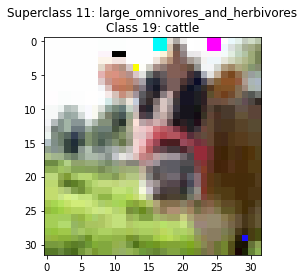

In [ ]:
# 3. Showing an example of wavelet-transformed image
show(images_train_wavelet,0)

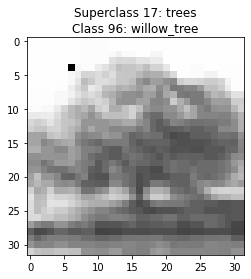

In [ ]:
# Another example of wavelet-transformed image
show(images_train_wavelet,11)

## ZCA whitening

In [ ]:
def zca(data_train, data_test, epsilon = 0.1, Norm=True,Centre=True):

    ## Normalise
    
    if Norm == True:
        data_train = data_train/255
        data_test = data_test/255
    
    ## Centre (for the covariance matrix)
    
    if Centre == True:
        mean = data_train.mean(axis=0)
        data_train = data_train - mean
        data_test = data_test - mean
    
    ## Covariance Matrix
    
    covariance_matrix = np.cov(data_train, rowvar=False)
    covariance_matrix_test = np.cov(data_test, rowvar=False)
    
    ## SVD of Covariance Matrix
    
    U,S,V = np.linalg.svd(covariance_matrix)
    Utest,Stest,Vtest = np.linalg.svd(covariance_matrix_test)
    

    ## ZCA Transform
    
    ### Epsilon is a hyper parameter we can tune, epsilon is 0.1 by default
    
    data_train_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(data_train.T).T

    data_test_ZCA = Utest.dot(np.diag(1.0/np.sqrt(Stest + epsilon))).dot(Utest.T).dot(data_test.T).T

    ## Normalise the ZCA result into the range 0 and 1
    
    if Norm == True:
        data_train_ZCA = (data_train_ZCA - data_train_ZCA.min()) / (data_train_ZCA.max() - data_train_ZCA.min())
    
        data_test_ZCA = (data_test_ZCA - data_test_ZCA.min()) / (data_test_ZCA.max() - data_test_ZCA.min())
    
    
    return data_train_ZCA, data_test_ZCA

In [ ]:
# 1. ZCA transform the data train and data test
data_train_ZCA, data_test_ZCA = zca(data_train, data_test)

# 2. Reshaping ZCA-transformed data
images_train_ZCA = data_to_images(data_train_ZCA)
X_test_ZCA = data_to_images(data_test_ZCA)

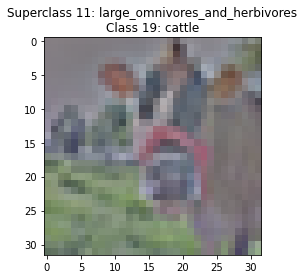

In [ ]:
# 3. Showing an example of ZCA-transformed image
show(images_train_ZCA,0)

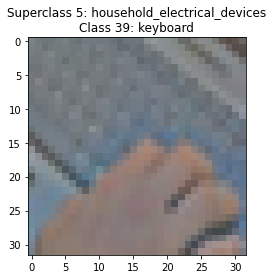

In [ ]:
# Another example of ZCA-transformed image
show(images_train_ZCA,10)

# Spliting data and preparations 

In [ ]:
## Following cells are proposed by Maria :)
## Note that data_train_XX is used to make sure the consistency in naming
## double "#" are comments to be deleted

# Here, we'll flatten our wavelet-transformed images to pass to KNN and Random Forest
data_train_wavelet = [images_train_wavelet[i].reshape((1,3072)).flatten() for i in range(len(images_train_wavelet))]

# Also, labels are converted into numpy arrays
coarse_labels_train_array = np.array(coarse_labels_train)
fine_labels_train_array = np.array(fine_labels_train)
coarse_labels_test_array = np.array(coarse_labels_test)
fine_labels_test_array = np.array(fine_labels_test)

## Standardised data

In [ ]:
X_train_standard, X_valid_standard, Y_train_standard, Y_valid_standard =\
 train_test_split(data_train_standard, coarse_labels_train_array, test_size=0.33, random_state=42)

In [ ]:
X_train_standard.shape # Checking shape of data

(33500, 3072)

In [ ]:
Y_train_standard.shape

(33500,)

In [ ]:
X_valid_standard.shape

(16500, 3072)

In [ ]:
Y_valid_standard.shape

(16500,)

## Wavelet-transformed data

In [ ]:
X_train_wavelet, X_valid_wavelet, Y_train_wavelet, Y_valid_wavelet =\
 train_test_split(data_train_wavelet, coarse_labels_train_array, test_size=0.33, random_state=42)

## ZCA-transformed data

In [ ]:
X_train_ZCA, X_valid_ZCA, Y_train_ZCA, Y_valid_ZCA =\
 train_test_split(data_train_ZCA, coarse_labels_train_array, test_size=0.33, random_state=42)

# Algorithms classes

## Gaussian Naive Bayes

In [ ]:
class GNB:
    
    """
    We created this class to store all the calculations related to our Gaussian Naive Bayes 
    Classifier.

    We included functions to:
    - Fit
    - Predict
    - Get accuracy
    - Get recall
    - Get precision
    - Get the confussion matrix
    """

    def __init__(self):
        self.prediction = None
        self.confusion_KNN = None
        self.fit_model = None
        self.gnb = GaussianNB()
        
    def fit(self, train, test):

        return self.gnb.fit(train, test)
    
    def predict(self, test):

        self.prediction = self.gnb.predict(test)
        
        return self.prediction
        
    def accuracy(self, label_test):
        return accuracy_score(label_test,self.prediction)

    def recall(self, label_test):
        return recall_score(label_test,self.prediction,average='macro')  

    def precision(self, label_test):  
        return precision_score(label_test,self.prediction,average='macro')  
        
    def confusion_matrix(self, label_test):
        return  confusion_matrix(label_test,self.prediction)

## Random Forest class

In [ ]:
class RandomForest:
    
    """
    We created this class to store all the calculations related to our Gaussian Naive Bayes 
    Classifier.

    We included functions to:
    - Fit
    - Predict
    - Predict using parameters given directly as input (in the case of the hyperpameters)
    - Get accuracy
    - Get recall
    - Get precision
    - Get the confussion matrix
    """

    def __init__(self):
        self.n_estimators = None
        self.min_samples_leaf = None
        self.best_params = None
        self.max_features = None
        self.max_depth = None
        self.rand_forest_withCV = None
        self.rf = RandomForestClassifier(random_state=42, n_jobs = -1)
        self.pred = None

        
    def cv(self, random_grid, train_set, label_train_set):
        
        """
        This will be a process of fitting using a set of different parameters to
        test in the random search cross-validation process. 
        --------------------------------------------------------
        Output: The values of the parameters
        """
        
        # 1. Creating the classifier

        # 2. Setting of the random serach CV
        self.rand_forest_withCV = RandomizedSearchCV(estimator = self.rf, \
                        param_distributions = random_grid, \
                        cv = 10, verbose = 2, n_jobs = -1, n_iter = 3)

        # 3. Fitting the model to the training set
        self.rand_forest_withCV.fit(train_set,label_train_set)
        
        
        self.best_params = self.rand_forest_withCV.best_params_
        
        self.n_estimators = self.best_params['n_estimators']
        self.min_samples_leaf = self.best_params['min_samples_leaf']
        self.max_features = self.best_params['max_features']
        self.max_depth = self.best_params['max_depth']
        
        return self.best_params
      
    def fitting(self, train_set, label_train_set):
        print(type(train_set), type(label_train_set))
        return self.rf.fit(train_set,label_train_set)
    
    def prediction(self, test_set):

        self.pred = self.rf.predict(test_set)
        
        return self.pred
        
    
    def prediction_params(self, train_set,label_train_set, test_set, n_est,\
                             mx_feat, mn_smp_leaf, mx_dpth):

        rf = RandomForestClassifier(n_estimators=n_est, max_features=mx_feat,\
                                    min_samples_leaf=mn_smp_leaf, max_depth=mx_dpth, random_state=42, n_jobs = -1)
        
        rf.fit(train_set,label_train_set)
        self.pred = rf.predict(test_set)

        return self.pred
      
    def accuracy(self, label_test):
        return accuracy_score(label_test,self.pred)

    def recall(self, label_test):
        return recall_score(label_test,self.pred,average='macro')

    def precision(self, label_test):  
        return precision_score(label_test,self.pred,average='macro')      
      
    def confusion_matrix(self, label_test):
        return  confusion_matrix(label_test,self.pred)

# Experimental Setting

# <b>STOP HERE!!!!!!!!</b>


## Experiments for Gaussian Naive Bayes

In [ ]:
"""start_time_GNB_std = time.time()
kf = KFold(n_splits=10)

cv_accuracy_list_std = []
cv_recall_list_std = []
cv_precision_list_std = []

i = 1
for tr_i, ts_i in kf.split(data_train_standard):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_standard[tr_i], data_train_standard[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Gaussian Naive Bayes classifier
    gnb_std = GNB()

    # 2. Training the model using the splits from the Kfold step
    gnb_std.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = gnb_std.predict(X_test)
    cv_accuracy_list_std.append(gnb_std.accuracy(y_test))
    cv_recall_list_std.append(gnb_std.recall(y_test))
    cv_precision_list_std.append(gnb_std.precision(y_test))
    
    i += 1
    del gnb_std, X_train, X_test, y_train, y_test, y_pred

time_GNB_std = time.time() - start_time_GNB_std"""

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)


the time spent in the 10-fold process is 36.80 seconds


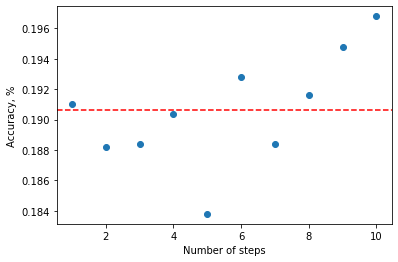

In [ ]:
"""plt.scatter(range(1, 11), cv_accuracy_list_std)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_std))

print("the time spent in the 10-fold process is {:.02f} seconds".format(time_GNB_std))"""

In [ ]:
"""time_GNB_std"""

38.18063521385193

### Pre-processed dataset

In [45]:
"""# WAVELET DATA
start_time_GNB_wv = time.time()
kf = KFold(n_splits=10)

cv_accuracy_list_wv = []
cv_recall_list_wv = []
cv_precision_list_wv = []

i = 1
data_train_wavelet = np.array(data_train_wavelet).astype(int)

for tr_i, ts_i in kf.split(data_train_wavelet):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_wavelet[tr_i], data_train_wavelet[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Gaussian Naive Bayes classifier
    gnb_wv = GNB()

    # 2. Training the model using the splits from the Kfold step
    gnb_wv.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = gnb_wv.predict(X_test)
    cv_accuracy_list_wv.append(gnb_wv.accuracy(y_test))
    cv_recall_list_wv.append(gnb_wv.recall(y_test))
    cv_precision_list_wv.append(gnb_wv.precision(y_test))
    
    i += 1
    del gnb_wv, X_train, X_test, y_train, y_test, y_pred

time_GNB_wv = time.time() - start_time_GNB_wv"""

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)


the time spent in the 10-fold process is 51.21 seconds


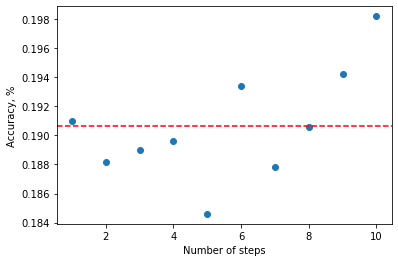

In [46]:
"""plt.scatter(range(1, 11), cv_accuracy_list_wv)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_wv))

print("the time spent in the 10-fold process is {:.02f} seconds".format(time_GNB_wv))"""

In [47]:
"""# ZCA data
start_time_GNB_zca = time.time()
kf = KFold(n_splits=10)

cv_accuracy_list_zca = []
cv_recall_list_zca = []
cv_precision_list_zca = []

i = 1
data_train_ZCA = np.array(data_train_ZCA).astype(int)

for tr_i, ts_i in kf.split(data_train_ZCA):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, " | TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_ZCA[tr_i], data_train_ZCA[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Gaussian Naive Bayes classifier
    gnb_zca = GNB()

    # 2. Training the model using the splits from the Kfold step
    gnb_zca.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = gnb_zca.predict(X_test)
    cv_accuracy_list_zca.append(gnb_zca.accuracy(y_test))
    cv_recall_list_zca.append(gnb_zca.recall(y_test))
    cv_precision_list_zca.append(gnb_zca.precision(y_test))
    
    i += 1
    del gnb_zca, X_train, X_test, y_train, y_test, y_pred

time_GNB_zca = time.time() - start_time_GNB_zca"""

Step:  1  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  2  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning: divide by zero encountered in true_divide
  (self.sigma_[i, :]), 1)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  3  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  4  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  5  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  6  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  7  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  8  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  9  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  10  | TRAIN:  (45000,)  | TEST:  (5000,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the time spent in the 10-fold process is 53.57 seconds


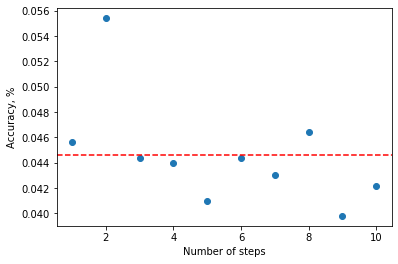

In [48]:
"""plt.scatter(range(1, 11), cv_accuracy_list_zca)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_zca))

print("the time spent in the 10-fold process is {:.02f} seconds".format(time_GNB_zca))"""

## Experiments for Random Forest

#### K-Fold Cross validation

In [49]:
"""# Standard Data

start_time_rf_std = time.time()
kf = KFold(n_splits=10)

cv_rf_accuracy_std = []
cv_rf_recall_std = []
cv_rf_precision_std = []

i = 1
for tr_i, ts_i in kf.split(data_train_standard):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_standard[tr_i], data_train_standard[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Random Forest classifier
    rf_std = RandomForest()

    # 2. Training the model using the splits from the Kfold step
    rf_std.fitting(X_train, y_train)

    #Predict the response for test dataset
    y_pred = rf_std.prediction(X_test)
    cv_rf_accuracy_std.append(rf_std.accuracy(y_test))
    cv_rf_recall_std.append(rf_std.recall(y_test))
    cv_rf_precision_std.append(rf_std.precision(y_test))
    
    i += 1
    del rf_std, X_train, X_test, y_train, y_test, y_pred

time_rf_std = time.time() - start_time_rf_std"""

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


17.379485404491426


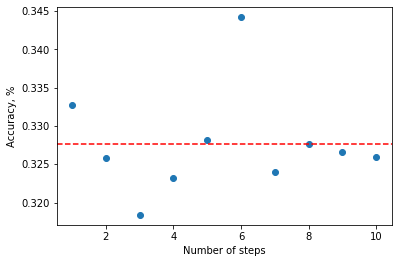

In [50]:
"""plt.scatter(range(1, 11), cv_rf_accuracy_std)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_rf_accuracy_std))

print(time_rf_std/60)"""

In [51]:
"""# Wavelet Data

start_time_rf_wv = time.time()
kf = KFold(n_splits=10)

cv_rf_accuracy_wv = []
cv_rf_recall_wv = []
cv_rf_precision_wv = []

i = 1
for tr_i, ts_i in kf.split(data_train_wavelet):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_wavelet[tr_i], data_train_wavelet[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Random Forest classifier
    rf_wv = RandomForest()

    # 2. Training the model using the splits from the Kfold step
    rf_wv.fitting(X_train, y_train)

    #Predict the response for test dataset
    y_pred = rf_wv.prediction(X_test)
    cv_rf_accuracy_wv.append(rf_wv.accuracy(y_test))
    cv_rf_recall_wv.append(rf_wv.recall(y_test))
    cv_rf_precision_wv.append(rf_wv.precision(y_test))
    
    i += 1
    del rf_wv, X_train, X_test, y_train, y_test, y_pred

time_rf_wv = time.time() - start_time_rf_wv"""

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


17.259157578150432


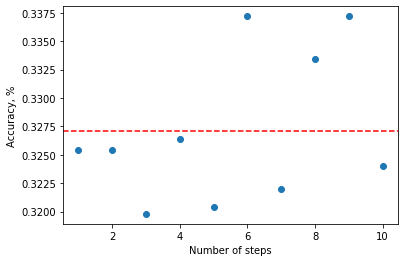

In [52]:
"""plt.scatter(range(1, 11), cv_rf_accuracy_wv)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_rf_accuracy_wv))

print(time_rf_wv/60)"""

In [54]:
"""start_time_rf_zca = time.time()
kf = KFold(n_splits=10)

cv_rf_accuracy_zca = []
cv_rf_recall_zca = []
cv_rf_precision_zca = []

i = 1
for tr_i, ts_i in kf.split(data_train_wavelet):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_train, X_test = data_train_ZCA[tr_i], data_train_ZCA[ts_i]
    y_train, y_test = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    # 1. Create a Random Forest classifier
    rf_zca = RandomForest()

    # 2. Training the model using the splits from the Kfold step
    rf_zca.fitting(X_train, y_train)

    #Predict the response for test dataset
    y_pred_zca = rf_zca.prediction(X_test)
    cv_rf_accuracy_zca.append(rf_zca.accuracy(y_test))
    cv_rf_recall_zca.append(rf_zca.recall(y_test))
    cv_rf_precision_zca.append(rf_zca.precision(y_test))
    
    i += 1
    del rf_zca, X_train, X_test, y_train, y_test, y_pred_zca

time_rf_zca = time.time() - start_time_rf_zca"""

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11.171177685260773


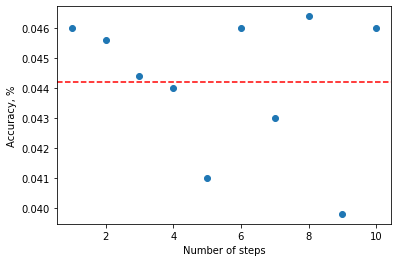

In [55]:
"""plt.scatter(range(1, 11), cv_rf_accuracy_zca)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_rf_accuracy_zca))

print(time_rf_zca/60)"""

## Comparing the three k-fold cross validations

In [68]:
"""# Gaussian NB average accuracy in the 10-fold cross validation process
gnb_avg_acc_std = np.average(cv_accuracy_list_std)
gnb_avg_acc_wv = np.average(cv_accuracy_list_wv)
gnb_avg_acc_zca = np.average(cv_accuracy_list_zca)

# Random forest
rf_avg_acc_std = np.average(cv_rf_accuracy_std)
rf_avg_acc_wv = np.average(cv_rf_accuracy_wv)
rf_avg_acc_zca = np.average(cv_rf_accuracy_zca)"""

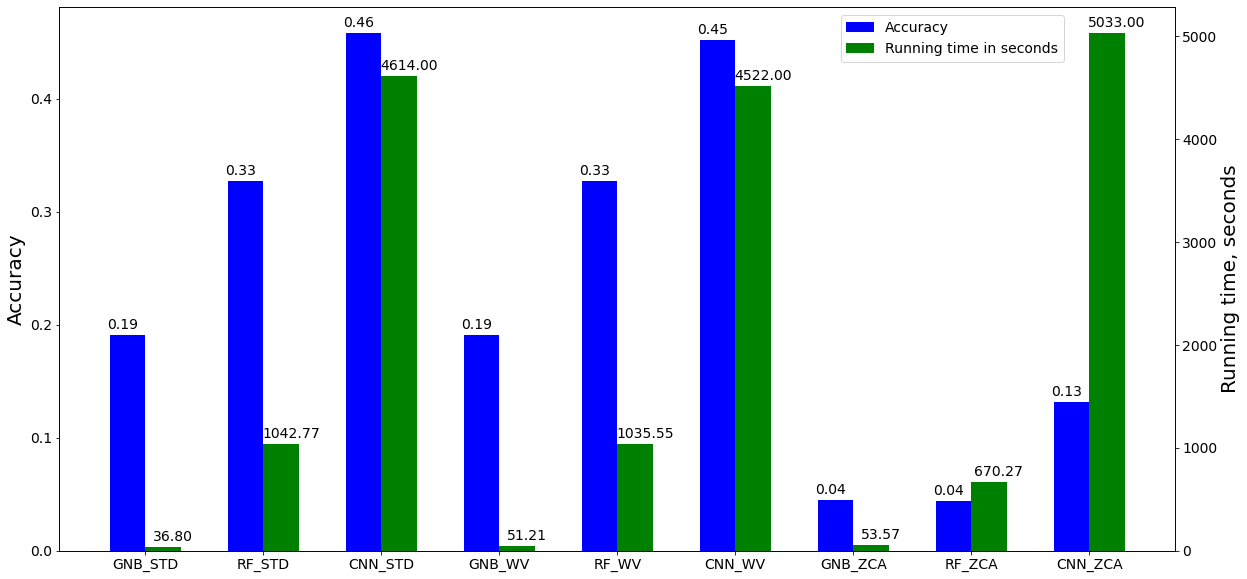

In [102]:
"""result = {'GNB_STD': gnb_avg_acc_std, 'RF_STD': rf_avg_acc_std, 'CNN_STD': 0.4582,\
          'GNB_WV': gnb_avg_acc_wv ,'RF_WV': rf_avg_acc_wv, 'CNN_WV': 0.4525,\
          'GNB_ZCA': gnb_avg_acc_zca,'RF_ZCA': rf_avg_acc_zca, 'CNN_ZCA': 0.1315}
          
keys_classifiers = list(result.keys())
accuracies_classifiers = list(result.values())
running_time = [time_GNB_std, time_rf_std, 4614, time_GNB_wv, time_rf_wv, 4522, time_GNB_zca, time_rf_zca, 5033 ]

x = np.arange(9) #names location
w = 0.3 #width of bar

# Bar 1- accuracy
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})
plt.xticks(x + w /2, keys_classifiers)
accuracy = ax1.bar(x, accuracies_classifiers, width=w, color='b', align='center')
plt.ylabel('Accuracy', size = 20)

# Bar 2- time
ax2 = ax1.twinx() #share same x as bar 1
plt.rcParams.update({'font.size': 14})
runningt =ax2.bar(x + w, running_time, width=w,color='g',align='center')
plt.ylabel('Running time, seconds', size = 20)

# Legends and annotation of values
plt.legend([accuracy, runningt],['Accuracy', 'Running time in seconds'],bbox_to_anchor=(.7, 0.9),\
           loc=(2,1), prop={"size":14})

for rect in accuracy:
  height = rect.get_height()
  ax1.annotate('{:.2f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(-5, 3),  # 3 points vertical offset
            textcoords="offset points", size = 14,
            ha='center', va='bottom')
  
for rect in runningt:
  height = rect.get_height()
  ax2.annotate('{:.2f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(10, 3), 
            textcoords="offset points", size = 14,
            ha='center', va='bottom')

plt.show()"""

# Hyperparameters fine-tuning

In [ ]:
"""
# 1. Definition of the set of possible hyperparameters of the model

n_estimators = [10, 50, 100, 200, 400, 600]
max_features = ['auto', 'sqrt','log2']
max_depth = [10, 20, 30, 40, 50,100,200,None]
min_samples_leaf = [1, 2, 5, 10]

# 2. Defining the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features ,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
"""

### Standard dataset

In [ ]:
"""# 1. Creating our object from the class classifier
random_forest_classifier = RandomForest()

# 2. The following aims for cross-validation and hyperparameters fine-tuning
params = random_forest_classifier.cv(random_grid, X_train_standard, Y_train_standard)
"""

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 78.6min finished


In [ ]:
"""params"""

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 600}

In [ ]:
"""# 3. Getting the predicted labels

max_depth = params['max_depth']
min_samples_leaf = params['min_samples_leaf']
max_features = params['max_features']
n_estimators = params['n_estimators']

random_forest_classifier.prediction_params(X_train_standard,Y_train_standard, X_valid_standard, n_estimators,\
                             max_features, min_samples_leaf, max_depth)

# 5. Getting acuuracy measures
accuracy_std_rf = random_forest_classifier.accuracy(Y_valid_standard)
recall_std_rf = random_forest_classifier.recall(Y_valid_standard)
precision_std_rf = random_forest_classifier.precision(Y_valid_standard)"""

In [ ]:
"""print("The accuracy is {:.08f}, recall is {:.08f}, and precision is {:.08f}".\
      format(accuracy_std_rf, recall_std_rf, precision_std_rf))"""

The accuracy is 0.33963636, recall is 0.33963636, and precision is 0.33963636


# Fitting to the train set

## <b>*START HERE AGAIN!!!!!*</b>

## GNB

In [75]:
## Gaussian Naive Bayes

start_gnb = time.time()
# 1. Create a Gaussian Naive Bayes classifier
gnb_test = GNB()

# 2. Training the model using the splits from the Kfold step
gnb_test.fit(X_train_standard, Y_train_standard)

#Predict the response for test dataset
y_pred = gnb_test.predict(data_test_standard)
gnb_test_accu = gnb_test.accuracy(coarse_labels_test)
gnb_test_recall = gnb_test.recall(coarse_labels_test)
gnb_test_prec = gnb_test.precision(coarse_labels_test)

end_gnb = time.time() - start_gnb

In [76]:
print("Accuracy analysis--.")
print("- Accuracy of gnb is {:.04f}".format(gnb_test_accu))
print("- Recall of gnb is {:.04f}".format(gnb_test_recall))
print("- Precision of gnb is {:.04f}".format(gnb_test_prec))
print("The time to run this algorithm is {:.03f} minutes ".format(end_gnb/60))

Accuracy analysis--.
- Accuracy of gnb is 0.1874
- Recall of gnb is 0.1874
- Precision of gnb is 0.1905
The time to run this algorithm is 0.096 minutes 


In [77]:
confusion_gnb_test = pd.DataFrame(gnb_test.confusion_matrix(coarse_labels_test))

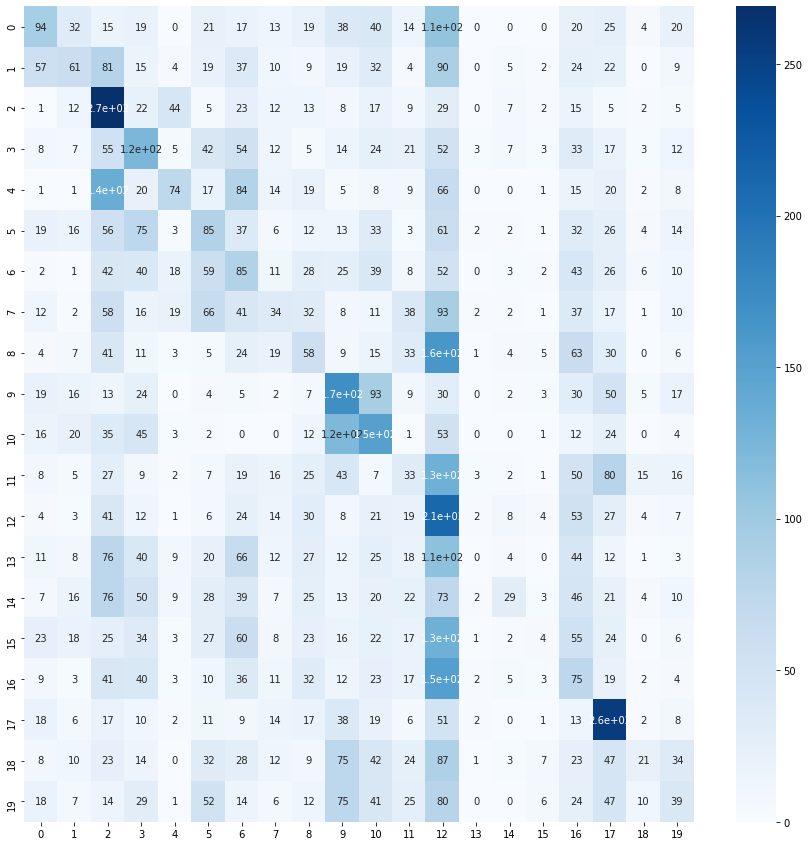

In [78]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(confusion_gnb_test, annot=True, cmap='Blues')

## Random Forest

As long as we know from the hyperparameters finetuning process that the best parameters are the ones in the next figure, we will apply them directly to a Random Forest Classifier. 

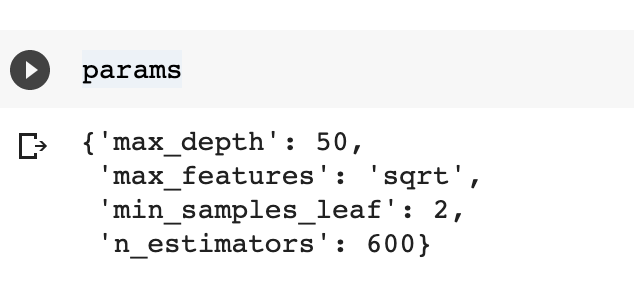

In [79]:
## Random Forest

# 1. Setting hyperparameters
mx_dpth = 50
n_est = 600
mx_feat = 'sqrt'
mn_smp_leaf = 2


start_rf = time.time()
# 1. Create a Random Forest classifier
rf_std_test = RandomForest()

# 1. Fit with parameters
y_pred = rf_std_test.prediction_params(X_train_standard, Y_train_standard, data_test_standard,\
                                       n_est,mx_feat,mn_smp_leaf,mx_dpth)

# 2. Predict the response for test dataset

rf_test_acc = rf_std_test.accuracy(coarse_labels_test)
rf_test_recall = rf_std_test.recall(coarse_labels_test)
rf_test_prec = rf_std_test.precision(coarse_labels_test)

end_rf = time.time() - start_rf 

In [80]:
print("Accuracy analysis--.")
print("- Accuracy of rf is {:.04f}".format(rf_test_acc))
print("- Recall of rf is {:.04f}".format(rf_test_recall))
print("- Precision of rf is {:.04f}".format(rf_test_prec))
print("The time to run this algorithm is {:.03f} minutes ".format(end_rf/60))

Accuracy analysis--.
- Accuracy of rf is 0.3450
- Recall of rf is 0.3450
- Precision of rf is 0.3441
The time to run this algorithm is 6.937 minutes 


In [81]:
confusion_rf_test = pd.DataFrame(rf_std_test.confusion_matrix(coarse_labels_test))

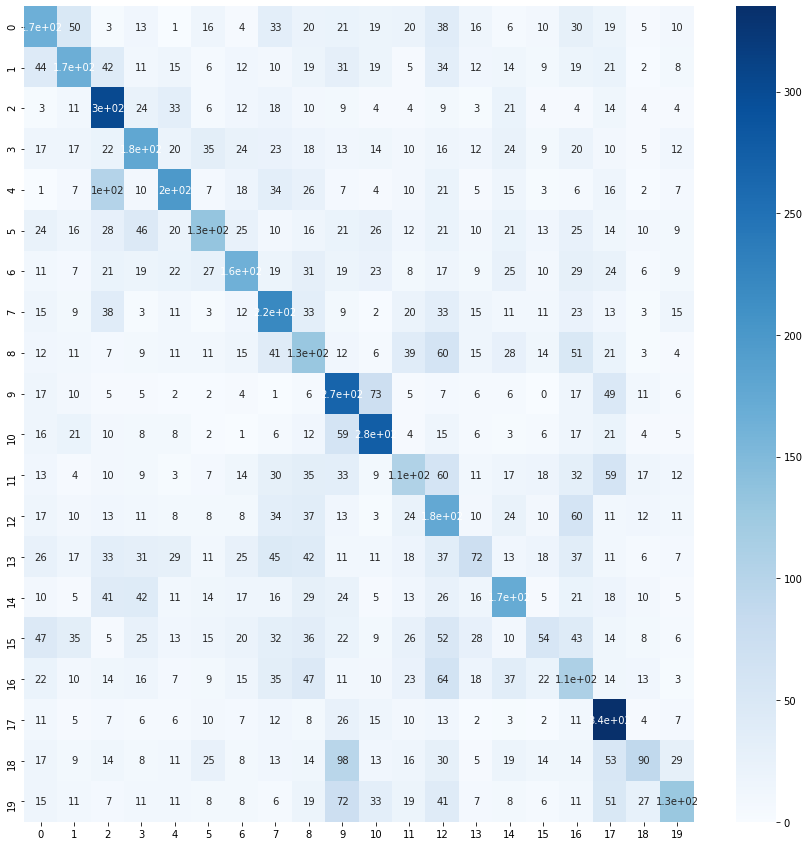

In [82]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(confusion_rf_test, annot=True, cmap='Blues')